In [2]:
import torch
torch.set_float32_matmul_precision('medium')
import numpy as np
import scipy
import pytorch_lightning as pl
from tqdm import tqdm
import plotfancy as pf
import matplotlib.pyplot as plt
pf.housestyle_rcparams()

import os, sys
sys.path.append('../../mist-base/GW')
sys.path.append('../../mist-base/')
sys.path.append('../../mist-base/utils')
sys.path.append('../../')

from src.utils.generators import Simulator_Additive
from simulators.utils import *
from utils.data import OnTheFlyDataModule, StoredDataModule
from utils.module import CustomLossModule_withBounds, BCELossModule

import logging

mycolors = ['#570f6d', "#9e8f92", '#f98e08']
folly = '#ff004f'

In [3]:
glob_sigma = 1
glob_bkg = True
glob_pve_bounds = False
glob_det = 'det'

Nsims = 100_000
Nbins = 100
train_bounds = 5

simulator = Simulator_Additive(Nbins=Nbins, sigma=glob_sigma, bounds=train_bounds, 
                               fraction=0.2, bkg=glob_bkg, dtype=torch.float32, 
                               mode='complex', pve_bounds=glob_pve_bounds, bump=glob_det)     
samples = simulator.sample(Nsims=Nsims)  

In [5]:
p_marker = 'p' if glob_pve_bounds == True else 'n'
b_marker = 'b' if glob_bkg == True else 'q'
s_marker = 'd' if glob_det == 'det' else 's'
s_marker = '_sym'
m_marker = '_m1'
netid = p_marker+b_marker+s_marker+str(train_bounds)+s_marker+m_marker

if not os.path.isdir('figs/'+netid):
    os.makedirs('figs/'+netid)

/tmp/ipykernel_2243720/2313080994.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


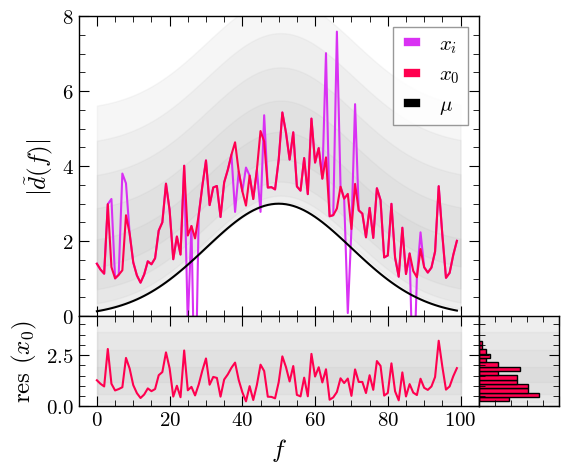

In [6]:
test = simulator.sample(1)
quantiles_long = np.array([7.1508466e-04, 7.9613253e-03, 5.1986761e-02,
       2.1462703e-01, 5.8794379e-01, 1.1776060e+00,
       1.9190179e+00, 2.7507384e+00, 3.6350725e+00,
       4.5491748e+00, 5.4850187e+00], dtype=np.float32)

pf.housestyle_rcparams()
fig, ax1 = pf.create_plot()

plt.setp(ax1.get_xticklabels(), visible=False)
ax2 = fig.add_axes((0,-.3,1,0.3), sharex=ax1)
ax3 = fig.add_axes((1,-.3,0.2,0.3), sharey=ax2)
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)

ax1.plot(test['xi'][0], label=r'$x_i$', color="#d931f3")
ax1.plot(test['x0'][0], label=r'$x_0$', color='#ff004f')
ax1.plot(test['mu'][0], label=r'$\mu$', color='black')
ax1.set_ylabel(r'$|\tilde{d}(f)|$')
ax1.set_ylim([0,8])
ax1.legend(loc='upper right')


resd = test['x0'][0]-test['mu'][0]
ax2.plot(resd, color='#ff004f')
ax2.set_xlabel(r'$f$')
ax2.set_ylabel(r'res ($x_0$)')
ax2.set_ylim([0,4.4])
grid = torch.linspace(0, 100, 100)
for i in range(1,6):
    ax1.fill_between(grid, quantiles_long[i]+test['mu'][0], quantiles_long[-i]+test['mu'][0],  color='#b0b0b0', alpha=0.1)
    ax2.fill_between(grid, quantiles_long[i], quantiles_long[-i],  color='#b0b0b0', alpha=0.1)
    ax3.fill_between(grid, quantiles_long[i], quantiles_long[-i],  color='#b0b0b0', alpha=0.1)

ax3.hist(resd, orientation='horizontal', bins=14, edgecolor='black', color='#ff004f', density=True)
ax3.set_xlim([0,1])

pf.fix_plot([ax1,ax2, ax3])
plt.tight_layout()

In [ ]:
from models.online_norm import OnlineStandardizingLayer
from models.resnet_1d import ResidualNet

class Network_epsilon(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.logvariance = torch.nn.Parameter(torch.ones(Nbins)*5)
        self.net = ResidualNet(1, 1, hidden_features=128, num_blocks=2, kernel_size=1, padding=0) 

    def forward(self, x):
        data = x['x']
        x = self.net(data.unsqueeze(1)).squeeze(1)
        return x
                
    def epsilon(self, x):
        x = self.net(x.unsqueeze(1)).squeeze(1) # x-net
        return x
    
    def snr(self, x):
        return self.epsilon(x) / self.logvariance.exp().sqrt()  # [B, N_bins]
    
    def bounds(self):
        return self.logvariance.detach().exp().sqrt().mean(-1) * 5
        
    def forward(self, x):
        
        # Adaptive data generation
        ni = x['ni']
        
        ###########################################
        epsilon_sim =  (self.bounds() * torch.rand(x['x'].shape,
                                                    device= x['x'].device, 
                                                    dtype= x['x'].dtype)) * ni
        ###########################################
        
        data =  x['x0'] + epsilon_sim * ni
        
        # data = x['x']
        epsilon = self.epsilon(data)
        mask = ( x['ni'] != 0 )  
        squared_error = (epsilon - epsilon_sim)**2                                                  # [B, N_bins]
        l = squared_error / (self.logvariance.exp() + 1e-10) + self.logvariance                     # [B, N_bins]
        return (l * mask.float()).sum() * 0.5

In [ ]:
# Train
def resample(sample):
    sample = simulator._resample(sample)
    sample['x'] = sample['xi']
    # sample = {k: v[0] for k, v in sample.items()}
    return sample

batch_size = 128
samples = simulator.sample(Nsims=Nsims)  
# dm = StoredDataModule(samples, batch_size=batch_size, on_after_load_sample=resample)
dm = OnTheFlyDataModule(simulator, Nsims_per_epoch=400*batch_size, batch_size=batch_size, num_workers=31)
network_epsilon = Network_epsilon()
model = CustomLossModule_withBounds(network_epsilon, learning_rate=3e-3)
trainer = pl.Trainer(
    accelerator="gpu", 
    max_epochs=20, 
    precision=64,
    # fast_dev_run=True
)
trainer.fit(model, dm)
network_epsilon.cuda().eval();

In [1]:
torch.save(network_epsilon, f'networks/network_e_{netid}_complex')
torch.save(model, f'networks/model_e_{netid}_complex')

NameError: name 'torch' is not defined

In [ ]:
# # Convert tensors to scalars if they are tensors
# train_loss_history = [loss.item() if hasattr(loss, 'item') else loss for loss in model.train_loss_history]
# bounds_history = [bound.item() if hasattr(bound, 'item') else bound for bound in model.bounds_history]

# # Generate a list of epoch numbers
# epochs = range(1, len(train_loss_history) + 1)

# fig, axs = plt.subplots(1, 2, figsize=(10, 3))
# # Plot Training Loss over Epochs
# axs[0].plot(epochs, train_loss_history)
# axs[0].set_xlabel('Epoch')
# axs[0].set_ylabel('Training Loss')
# # Plot Bounds over Epochs
# axs[1].plot(epochs, bounds_history, label='Bounds', color='orange')
# axs[1].set_xlabel('Epoch')
# axs[1].set_ylabel('Bounds')
# plt.tight_layout()
# plt.savefig(f'figs/{netid}/bounds.png', dpi=300)
# plt.tight_layout();

# network_epsilon.bounds()

# # Distotions enveloping the data
# bounds_history = [bound.item() if hasattr(bound, 'item') else bound for bound in model.bounds_history]
# sample = simulator.sample(1)
# ni = sample['ni']

# fig, axs = plt.subplots(4, 5, figsize=(20, (4+1)*3), sharex=True)
# axs = axs.flatten()
# for i_b, b in enumerate(bounds_history):
#     if i_b < len(axs):
#         axs[i_b].set_title(r"$b$ = {:.2f}".format(b))
#         for j in range(10):
#             sample = simulator.sample(1)
#             ni = sample['ni']
#             # axs[i_b].plot(sample['mu'][0].cpu(), c='k', ls='--')
#             epsilon_sim =  (2 * b * torch.rand(sample['xi'].shape, device= sample['xi'].device, dtype= sample['xi'].dtype) - b) * ni
#             data =  sample['x0'] + epsilon_sim * ni
#             axs[i_b].plot(data[0].cpu(), c='C0', alpha=0.4)
# plt.tight_layout()
# # plt.savefig(f'figs/{netid}/history.png', dpi=300)